# WEkEO Hackaton

With two friends, we've been participating hackaton organized by [WEkEO](https://www.wekeo.eu/) during the summer of 2022. There were several themes for the hackaton, but we decided to apply for the machine learning and data visualization track. Our plan was to study how lakes tended to loose water surface over time, due to climate change and overexploitation for agriculture.

The plan was as follow: our first friend, specialized in environmental sciences, would find an interesting lake to study, the the other friend would acquire and stabilize satellite data, and finally, I would try to find how the surface area of the lake changes over time, using machine learning.

The full set of notebooks, with data and proper explanations, is still undisclosed (we'll wait for the result of the hackaton for that), but here's my part of the work already.

### Imports

We start by importing a vast amount of modules, used for data analysis and visualization.

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import os
import zarr
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.segmentation import morphological_chan_vese
import cv2
import imutils
from scipy.signal import savgol_filter
import datetime
from scipy.interpolate import interp1d
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Prettier plots
import seaborn as sn
sn.set_style("white")

# High resolution plot
import matplotlib_inline.backend_inline as backend_inline
backend_inline.set_matplotlib_formats("png2x")

# Move to root directory for browsing
os.chdir("..")


As the whole pipeline comprises many images, I set some variables in order not to display everything, to make things more readable. Also, the analysis is quite long to execute (~1h), so I don't want to run it everytime I recompute the notebook outputs.

In [2]:
# Choose if intermediary plots must be displayed
INTERMEDIARY_PLOTS = False

# Choose if segmentation must be recomputed (it can take a long time)
COMPUTE_SEGMENTATION = False

# Choose if the visualization is interactive or not (doesn't work with online display)
INTERACTIVE = False

### Load data

I start by loading the dataset, which is a mix of Pandas dataframe and numpy arrays. The data is voluntarily not made available for now.

In [3]:
# Load all dataframes in a list
l_df = []
for file in os.listdir("Data engineering"):
    if file.endswith(".pickle"):
        df_temp = pd.read_pickle("Data engineering/" + file)
        df_temp["year"] = int(file.split("_")[0])
        l_df.append(df_temp)

# Merge all dataframes
df = pd.concat(l_df, axis=0)

# Remove useless columns
df = df[
    [
        "datatakesensingstart",
        "beginposition",
        "endposition",
        "ingestiondate",
        "processinglevel",
        "platformname",
        "size",
        "year",
    ]
]

# Sort by date
df = df.sort_values(by="beginposition")

# Delete initial list of dataframes
del l_df

df


datatakesensingstart  \
411c4c16-ed88-42af-a8e2-9a1414af3a62 2016-01-05 14:37:32.029   
4baae820-6e86-4301-9c4c-590311459b04 2016-01-22 14:29:42.030   
9aa597a5-e1cc-45af-97df-655f12eeabe5 2016-02-04 14:37:22.029   
4e3062c2-018c-49a5-8037-b7b9b9eaf407 2016-02-11 14:42:12.029   
feeab6d4-6768-4da7-a0e2-d9ca3d856c20 2016-03-02 14:42:02.030   
...                                                      ...   
4093f883-6257-4827-9b8e-64d6a13d58e1 2022-05-23 14:37:31.024   
884fff44-99f2-4bd5-a571-6fe53ccb3d15 2022-05-28 14:37:29.024   
b31187b3-349f-4988-96ed-305692e738a8 2022-06-02 14:37:41.024   
9cb65394-097c-40c0-bee0-1eb2849acb67 2022-06-07 14:37:29.024   
ecd7dced-1c5e-4abe-a188-0635758907ff 2022-06-12 14:37:41.024   

                                               beginposition  \
411c4c16-ed88-42af-a8e2-9a1414af3a62 2016-01-05 14:37:32.029   
4baae820-6e86-4301-9c4c-590311459b04 2016-01-22 14:29:42.030   
9aa597a5-e1cc-45af-97df-655f12eeabe5 2016-02-04 14:37:22.029   
4e3062c2-018c-49a5-8037-b7b9b9eaf407 2016-02-11 14:42:12.029   
feeab6d4-6768-4da7-a0e2-d9ca3d856c20 2016-03-02 14:42:02.030   
...                                                      ...   
4093f883-6257-4827-9b8e-64d6a13d58e1 2022-05-23 14:37:31.024   
884fff44-99f2-4bd5-a571-6fe53ccb3d15 2022-05-28 14:37:29.024   
b31187b3-349f-4988-96ed-305692e738a8 2022-06-02 14:37:41.024   
9cb65394-097c-40c0-bee0-1eb2849acb67 2022-06-07 14:37:29.024   
ecd7dced-1c5e-4abe-a188-0635758907ff 2022-06-12 14:37:41.024   

                                                 endposition  \
411c4c16-ed88-42af-a8e2-9a1414af3a62 2016-01-05 14:37:32.029   
4baae820-6e86-4301-9c4c-590311459b04 2016-01-22 14:29:42.030   
9aa597a5-e1cc-45af-97df-655f12eeabe5 2016-02-04 14:37:22.029   
4e3062c2-018c-49a5-8037-b7b9b9eaf407 2016-02-11 14:42:12.029   
feeab6d4-6768-4da7-a0e2-d9ca3d856c20 2016-03-02 14:42:02.030   
...                                                      ...   
4093f883-6257-4827-9b8e-64d6a13d58e1 2022-05-23 14:37:31.024   
884fff44-99f2-4bd5-a571-6fe53ccb3d15 2022-05-28 14:37:29.024   
b31187b3-349f-4988-96ed-305692e738a8 2022-06-02 14:37:41.024   
9cb65394-097c-40c0-bee0-1eb2849acb67 2022-06-07 14:37:29.024   
ecd7dced-1c5e-4abe-a188-0635758907ff 2022-06-12 14:37:41.024   

                                               ingestiondate processinglevel  \
411c4c16-ed88-42af-a8e2-9a1414af3a62 2018-12-18 19:07:14.311        Level-1C   
4baae820-6e86-4301-9c4c-590311459b04 2018-12-14 16:58:06.033        Level-1C   
9aa597a5-e1cc-45af-97df-655f12eeabe5 2018-12-07 19:45:55.926        Level-1C   
4e3062c2-018c-49a5-8037-b7b9b9eaf407 2018-12-08 12:46:18.299        Level-1C   
feeab6d4-6768-4da7-a0e2-d9ca3d856c20 2018-12-06 04:22:04.990        Level-1C   
...                                                      ...             ...   
4093f883-6257-4827-9b8e-64d6a13d58e1 2022-05-23 22:24:32.282        Level-1C   
884fff44-99f2-4bd5-a571-6fe53ccb3d15 2022-05-28 19:54:16.107        Level-1C   
b31187b3-349f-4988-96ed-305692e738a8 2022-06-02 23:14:05.200        Level-1C   
9cb65394-097c-40c0-bee0-1eb2849acb67 2022-06-07 19:38:38.627        Level-1C   
ecd7dced-1c5e-4abe-a188-0635758907ff 2022-06-12 22:16:36.674        Level-1C   

                                     platformname       size  year  
411c4c16-ed88-42af-a8e2-9a1414af3a62   Sentinel-2  635.49 MB  2016  
4baae820-6e86-4301-9c4c-590311459b04   Sentinel-2  378.96 MB  2016  
9aa597a5-e1cc-45af-97df-655f12eeabe5   Sentinel-2  811.35 MB  2016  
4e3062c2-018c-49a5-8037-b7b9b9eaf407   Sentinel-2  301.32 MB  2016  
feeab6d4-6768-4da7-a0e2-d9ca3d856c20   Sentinel-2  288.34 MB  2016  
...                                           ...        ...   ...  
4093f883-6257-4827-9b8e-64d6a13d58e1   Sentinel-2  645.87 MB  2022  
884fff44-99f2-4bd5-a571-6fe53ccb3d15   Sentinel-2  633.39 MB  2022  
b31187b3-349f-4988-96ed-305692e738a8   Sentinel-2  799.76 MB  2022  
9cb65394-097c-40c0-bee0-1eb2849acb67   Sentinel-2  739.14 MB  2022  
ecd7dced-1c5e

In [4]:
# Load all arrays in memory
l_arrays = []
for index, year in zip(df.index, df.year):
    with zarr.open("Data engineering/" + str(year) + ".zarr", mode="r") as img:
        try:
            l_arrays.append(img[index][:])
        except Exception as e:
            print(year, e)


# Convert to numpy array
array_data = np.array(l_arrays)

# Free memory
del l_arrays

print(array_data.size / 1024**2)
print(array_data.shape)


2018 '0cc7465a-0c11-4632-84e2-8270f3af9cc1'
2018 '16f05a46-af68-4f19-b456-df666a234afd'
2018 'ca15fcef-6c37-443a-aac7-e21f9209d4a2'
2018 '98abb80d-4bbd-4c68-8f54-160d3b63c4de'
2018 '50459dce-5be0-4a04-b25a-35532f9abca1'
2018 '3f40465b-e568-4a9f-8045-5d1b25dba296'
2018 '1ce63d22-7bab-44d6-ac17-6fbdb83814fe'
2018 'a9703d1f-3b62-444d-95b4-48a732397e3b'
4978.694915771484
(388, 13, 900, 1150)


In [5]:
# Remove 9th dimension as it's unusable
array_data = np.delete(array_data, 9, axis=1)

In [6]:
# Rearange data
array_data = np.swapaxes(array_data, 1, 2)
array_data = np.swapaxes(array_data, 2, 3)
print(array_data.shape)


(388, 900, 1150, 12)


In [7]:
# Crop images as they're too large for ML on a laptop
array_data = array_data[:, 150:551, 150:751, :]


In [8]:
# Normalize by the 90th percentile for RGB channels
percentile = np.percentile(array_data[:, :, :, (1, 2, 3)], 90)
for ax in [1, 2, 3]:
    array_data[:, :, :, ax] = (
        array_data[:, :, :, ax].astype(np.float64) / percentile * 255
    ).astype(np.int16)
    # Cap values above 255
    array_data[:, :, :, ax] = np.clip(array_data[:, :, :, ax], 0, 255)


### Try to visualize the data

I here code a function to display the data through a ipywidget, allowing to change time (image) and satellite channels interactively. However, this interaction is not supported on my React-made portfolio yet, so I code another function, static, as an alternative.

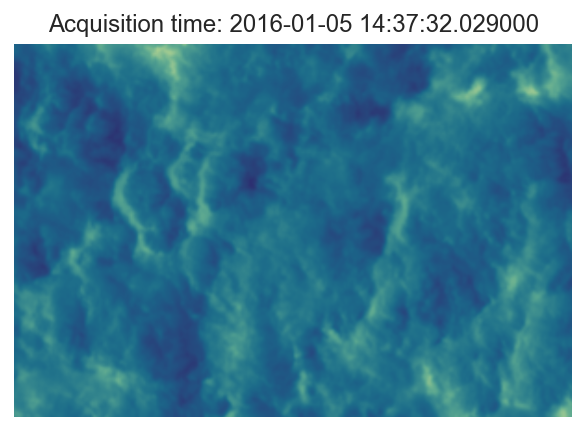

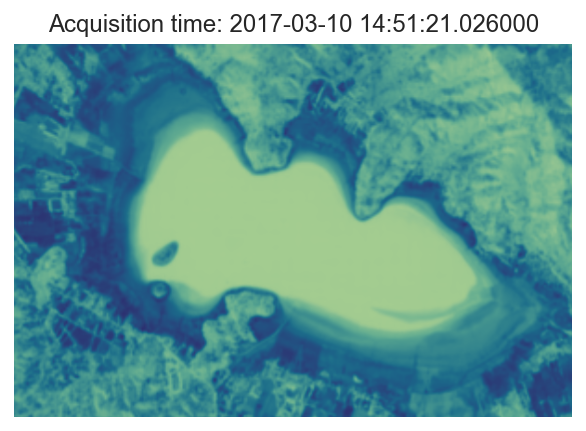

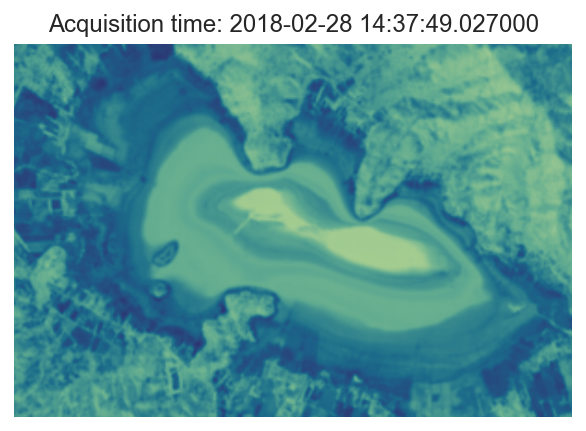

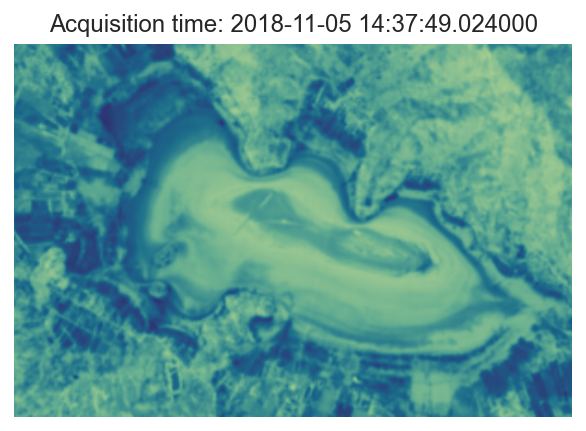

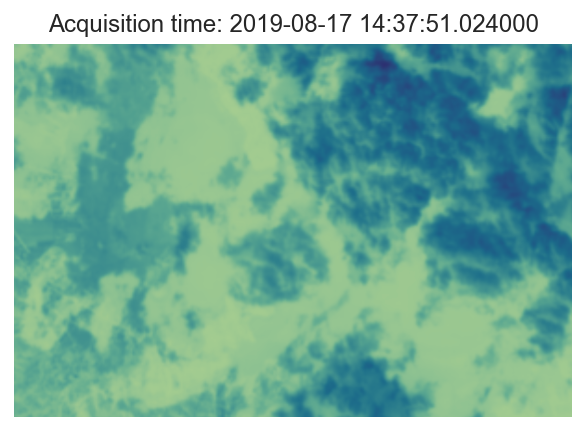

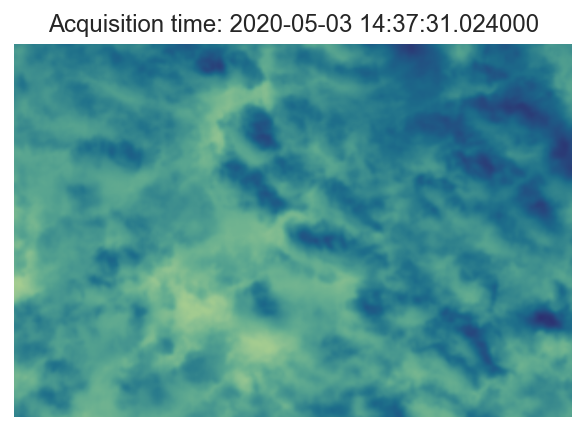

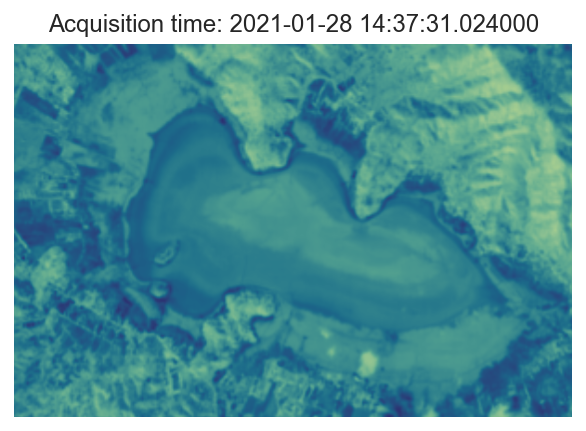

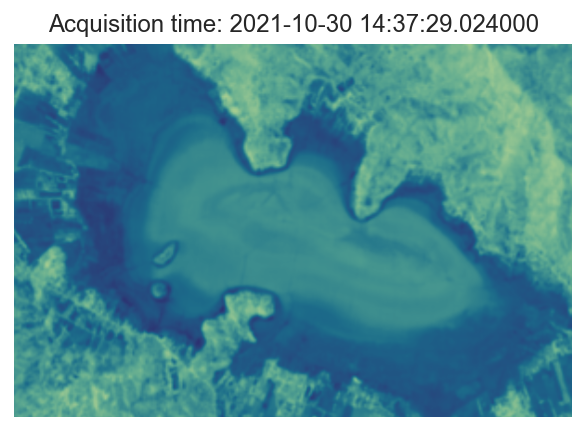

In [9]:
def visualize_data_interactive(array_data, array_segments=None, array_times=None):
    # Widget slider to browse the data
    index = widgets.IntSlider(
        value=5, min=0, max=array_data.shape[0] - 1, step=1, description="Index"
    )

    # Other widget slider to browse the channels
    channel = widgets.IntSlider(
        value=5, min=0, max=array_data.shape[3] - 1, step=1, description="Channel"
    )

    # Checkbox to display RGB (override the channel)
    display_RGB = widgets.Checkbox(description="Display RGB", value=False)

    ui = widgets.HBox([index, channel, display_RGB])

    # Widget interaction function
    def anim(index_value, channel_value, display_RGB_value):
        fig = plt.figure(figsize=(10, 8))
        if display_RGB_value:
            plt.imshow(array_data[index_value, :, :, (3, 2, 1)].swapaxes(0, 1).swapaxes(1, 2))
        else:
            plt.imshow(array_data[index_value, :, :, channel_value], cmap="crest")
        if array_segments is not None:
            if np.sum(array_segments[index_value]) > 0:
                plt.contour(array_segments[index_value], [0.5], colors="r")
        if array_times is not None:
            plt.title("Acquisition time: " + str(array_times[index_value]))
        else:
            plt.title("Acquisition time: " + str(df["beginposition"][index_value]))
        plt.axis("off")
        return

    # Link widget and function
    out = widgets.interactive_output(
        anim, {"index_value": index, "channel_value": channel, "display_RGB_value": display_RGB}
    )

    # Display result
    return ui, out


# Widget interaction function
def visualize_data_static(array_data, index_value, channel_value = 9, display_RGB_value = False, array_segments=None, array_times=None):

    fig = plt.figure(figsize=(5, 4))
    if display_RGB_value:
        plt.imshow(array_data[index_value, :, :, (3, 2, 1)].swapaxes(0, 1).swapaxes(1, 2))
    else:
        plt.imshow(array_data[index_value, :, :, channel_value], cmap="crest")
    if array_segments is not None:
        if np.sum(array_segments[index_value]) > 0:
            plt.contour(array_segments[index_value], [0.5], colors="r")
    if array_times is not None:
        plt.title("Acquisition time: " + str(array_times[index_value]))
    else:
        plt.title("Acquisition time: " + str(df["beginposition"][index_value]))
    plt.axis("off")
    plt.show()

if INTERACTIVE:
    ui, out = visualize_data_interactive(array_data)
    display(ui, out)
else:
    for i in range(0,array_data.shape[0],50):
        visualize_data_static(array_data, i)


### Discard most clouds and black images

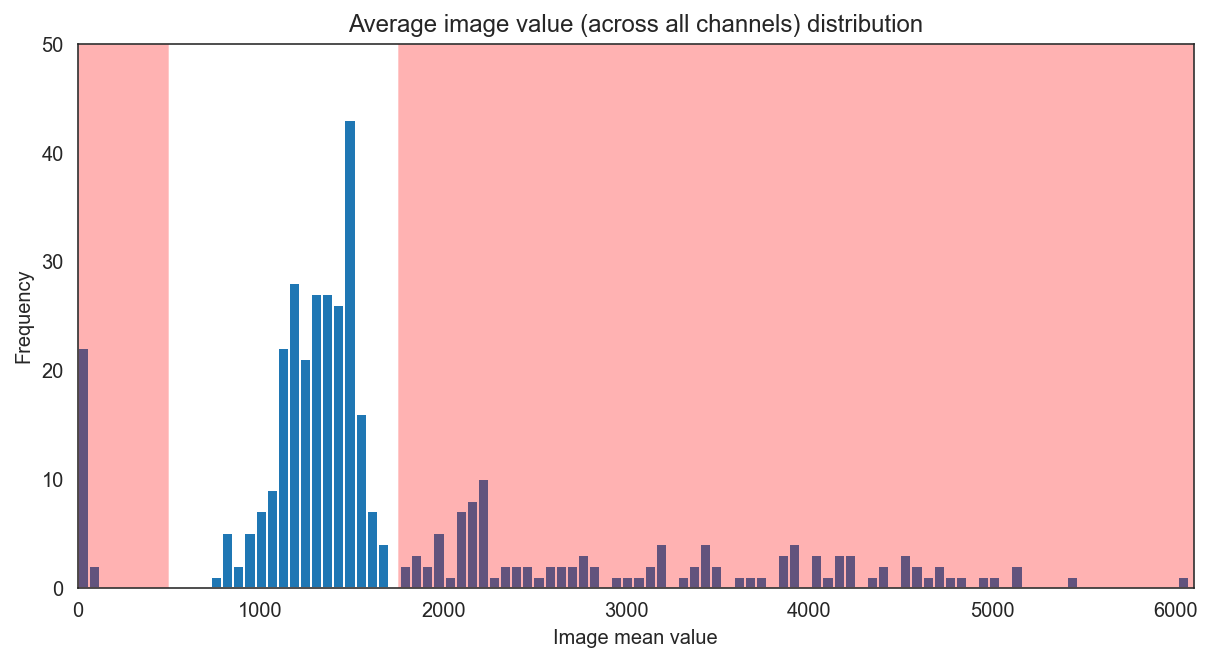

In [10]:
# Compute mean value of the image and check outliers
l_mean = [np.mean(x.flatten()) for x in array_data[:, :, :, :]]
lb, hb = 500, 1750

# Create figure and axes
fig, ax = plt.subplots(1, figsize=(10, 5))
plt.hist(l_mean, bins=100)
plt.ylim(0, 50)
plt.xlim(0, 6100)
plt.xlabel("Image mean value")
plt.ylabel("Frequency")

# Create two rectangle patches to show discarded data and add them to the plot
rect = patches.Rectangle((0, 0), lb, 50, alpha=0.3, facecolor="red")
rect2 = patches.Rectangle((hb, 0), 6100 - hb, 50, alpha=0.3, facecolor="red")
ax.add_patch(rect)
ax.add_patch(rect2)
plt.title("Average image value (across all channels) distribution")
plt.show()


In [11]:
# Discard images out of selected threshold
l_idx_to_keep = [idx for idx, m in enumerate(l_mean) if m > lb and m < hb]
array_data_cropped = array_data[l_idx_to_keep, :, :, :]
array_times = [df["beginposition"][index_value] for index_value in l_idx_to_keep]

if INTERMEDIARY_PLOTS:
    # Display result after this filtering
    if INTERACTIVE:
        ui, out = visualize_data_interactive(array_data_cropped)
        display(ui, out)
    else:
        for i in range(0,array_data_cropped.shape[0],20):
            visualize_data_static(array_data_cropped, i,array_times=array_times)

### Segment with active contour model

Now that our dataset is _relatively_ clean, we can try to segment the lake surface using an active contour model. More precisely, we use Morphological Active Contours without Edges, as it's the model that yields the best performance for this dataset. One drawnback is the impossibility to segment not star-convex shapes, but that shouldn't be an issue with our lake (or with almost any lake).

In [12]:
if COMPUTE_SEGMENTATION:
    # Segment all images in the dataset on channel 9 (# ! Takes ~1h to run)
    l_segmented_images = []
    for image in array_data_cropped[:, :, :, 9]:
        image_normalized = image / np.max(image)
        l_segmented_images.append(
            morphological_chan_vese(
                image_normalized,
                num_iter=200,
                init_level_set="disk",
                smoothing=2,
                lambda1=10.0,
                lambda2=1.0,
            )
        )

    array_segmented_images = np.array(l_segmented_images)
    del l_segmented_images

    # Store result as it's pretty heavy to compute
    with open("Notebooks/segmentation.npy", "wb") as f:
        np.save(f, array_segmented_images)
else:
    array_segmented_images = np.load("Notebooks/segmentation.npy")

if INTERMEDIARY_PLOTS:
    # Display segmentation result
    if INTERACTIVE:
        ui, out = visualize_data_interactive(
            array_data_cropped, array_segments=array_segmented_images, array_times=array_times
        )
        display(ui, out)
    else:
        for i in range(0,array_data_cropped.shape[0],20):
            visualize_data_static(
                array_data_cropped, i, array_segments=array_segmented_images, array_times=array_times
            )


In [13]:
# Filter out segments that are 80% smaller than the main segment
for index, segment in enumerate(array_segmented_images):
    try:
        cnts = cv2.findContours(segment.astype("uint8"), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
        rect_areas = []
        for c in cnts:
            (x, y, w, h) = cv2.boundingRect(c)
            rect_areas.append(w * h)
        max_area = np.max(rect_areas)
        for c in cnts:
            (x, y, w, h) = cv2.boundingRect(c)
            cnt_area = w * h
            if cnt_area < 0.2 * max_area:
                segment[y : y + h, x : x + w] = 0
        array_segmented_images[index] = segment
    except Exception as e:
        print(e)

if INTERMEDIARY_PLOTS:
    # Display result after filtering for small segments
    if INTERACTIVE:
        ui, out = visualize_data_interactive(
            array_data_cropped, array_segments=array_segmented_images, array_times=array_times
        )
        display(ui, out)
    else:
        for i in range(0,array_data_cropped.shape[0],20):
            visualize_data_static(
                array_data_cropped, i, array_segments=array_segmented_images, array_times=array_times
            )


zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity


In [14]:
# Filter out segments out segments that are outside of the largest segment when the lake is the
# fullest (among the first images, as it becomes empty afterwards)
biggest_segment_index = np.argmax([np.sum(x) for x in array_segmented_images[:20]])
biggest_segment = array_segmented_images[biggest_segment_index]
for index, segment in enumerate(array_segmented_images):
    segment_diff = biggest_segment - segment
    segment[segment_diff < 0] = 0
    array_segmented_images[index] = segment

if INTERMEDIARY_PLOTS:
    # Display result
    if INTERACTIVE:
        ui, out = visualize_data_interactive(
            array_data_cropped, array_segments=array_segmented_images, array_times=array_times
        )
        display(ui, out)
    else:
        for i in range(0,array_data_cropped.shape[0],20):
            visualize_data_static(
                array_data_cropped, i, array_segments=array_segmented_images, array_times=array_times
            )


### More filtering based on water content

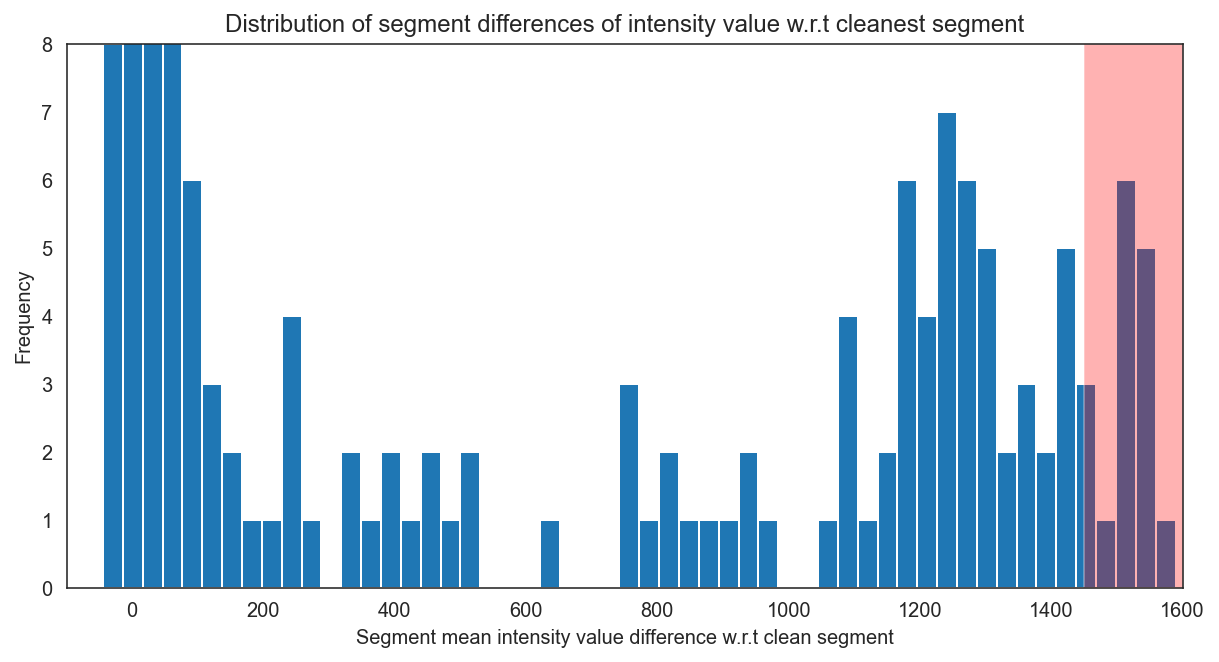

In [15]:
# Display distribution of intensity difference with 'pure' lake
fig, ax = plt.subplots(1, figsize=(10, 5))
l_diff_mean_segments = [
    np.mean(array_data_cropped[index, :, :, 9][segment == 1])
    - np.mean(array_data_cropped[biggest_segment_index, :, :, 9][biggest_segment == 1])
    if np.sum(segment) > 0
    else np.nan
    for index, segment in enumerate(array_segmented_images)
]
plt.hist(l_diff_mean_segments, bins=100)
plt.ylim(0, 8)
plt.xlim(-100, 1600)
plt.xlabel("Segment mean intensity value difference w.r.t clean segment")
plt.ylabel("Frequency")
tresh = 1450

# Create one rectangle patch and add it to the plot
rect = patches.Rectangle((tresh, 0), 1600 - tresh, 8, alpha=0.3, facecolor="red")
ax.add_patch(rect)
plt.title("Distribution of segment differences of intensity value w.r.t cleanest segment")
plt.show()


In [16]:
# Filter out segments that have an intensity which is significantly different from when the lake is the purest
array_segmented_images = np.array(
    [
        segment
        if (l_diff_mean_segments[index] < tresh and not np.isnan(l_diff_mean_segments[index]))
        else np.zeros_like(segment)
        for index, segment in enumerate(array_segmented_images)
    ]
)

if INTERMEDIARY_PLOTS:
    # Display result
    if INTERACTIVE:
        ui, out = visualize_data_interactive(
            array_data_cropped, array_segments=array_segmented_images, array_times=array_times
        )
        display(ui, out)
    else:
        for i in range(0,array_data_cropped.shape[0],20):
            visualize_data_static(
                array_data_cropped, i, array_segments=array_segmented_images, array_times=array_times
            )


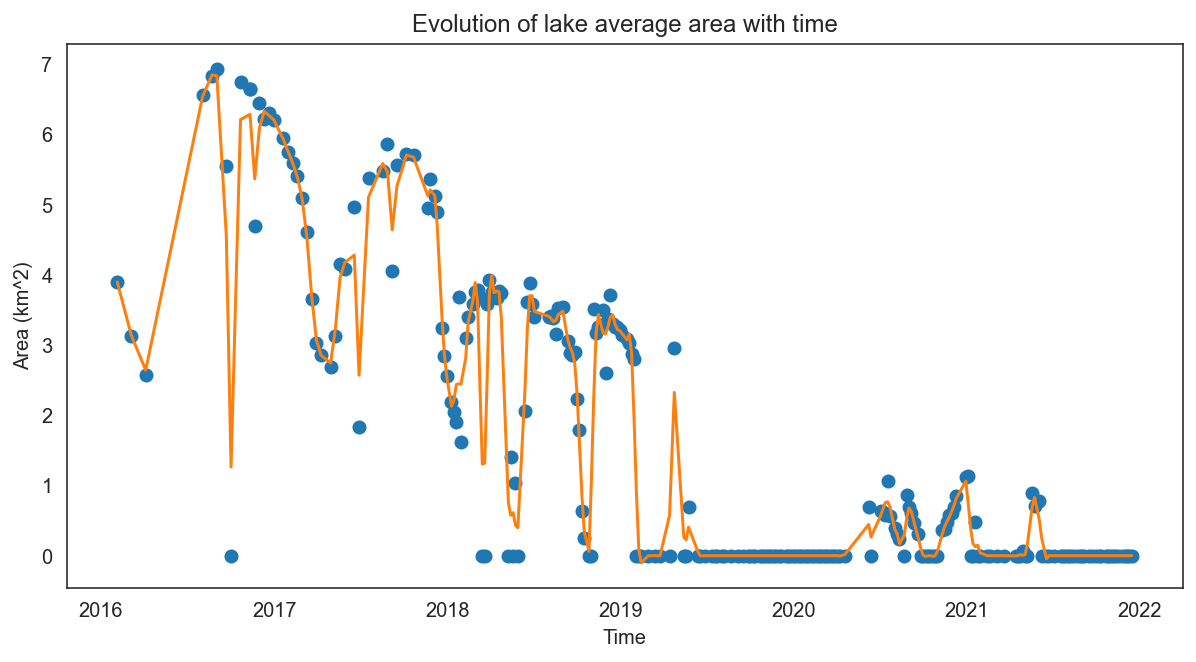

In [17]:
# Display area and detect images with abrupt change in segment with respect to the the previous and the next one
array_area = np.array([np.sum(segment) for index, segment in enumerate(array_segmented_images)])

# Get time in proper units
array_times_int = np.array(
    [(x - datetime.datetime(1970, 1, 1)).total_seconds() for x in array_times]
)
array_times_int = (array_times_int - array_times_int[0]) / 10**6

# Interpolate the signal with a regular sampling for smoothing afterwards
f = interp1d(array_times_int, array_area, kind="linear")
xnew = np.linspace(0, array_times_int[-1], num=500, endpoint=True)
y_new = f(xnew)

# Smooth the signal with a Savgol filter
yhat = savgol_filter(y_new, 7, 3)  # window size 7, polynomial order 3

# Reinterpolate
f = interp1d(xnew, yhat, kind="linear")
y_hat_proper_sampling = f(array_times_int)


# Plot the smoothed signal
plt.figure(figsize=(10, 5))
plt.plot(
    array_times,
    array_area * 100 / 1000000,
    "o",
    array_times,
    y_hat_proper_sampling * 100 / 1000000,
    "-",
)
plt.xlabel("Time")
plt.ylabel("Area (km^2)")
plt.title("Evolution of lake average area with time")
plt.show()


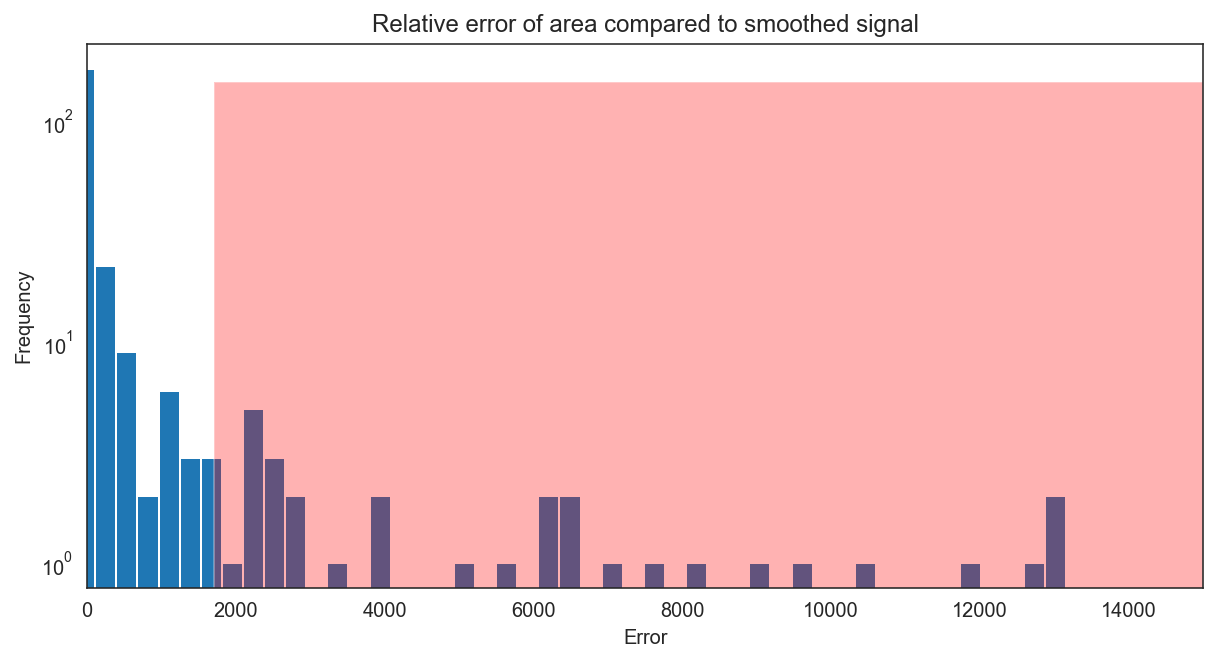

In [18]:
# Plot histogram of relative error compared to smoothed signal
fig, ax = plt.subplots(1, figsize=(10, 5))
l_relative_error = (array_area - y_hat_proper_sampling) ** 2 / np.array(y_hat_proper_sampling + 1)
plt.hist(l_relative_error, bins=50)
plt.xlim(0, 15000)
plt.xlabel("Error")
plt.ylabel("Frequency")
tresh = 1700
# Create one rectangle patch and add it to the plot
rect = patches.Rectangle((tresh, 0), 15000 - tresh, 150, alpha=0.3, facecolor="red")
ax.add_patch(rect)

ax.set_yscale("log")
# plt.ylim(0,150)
plt.title("Relative error of area compared to smoothed signal")

plt.show()


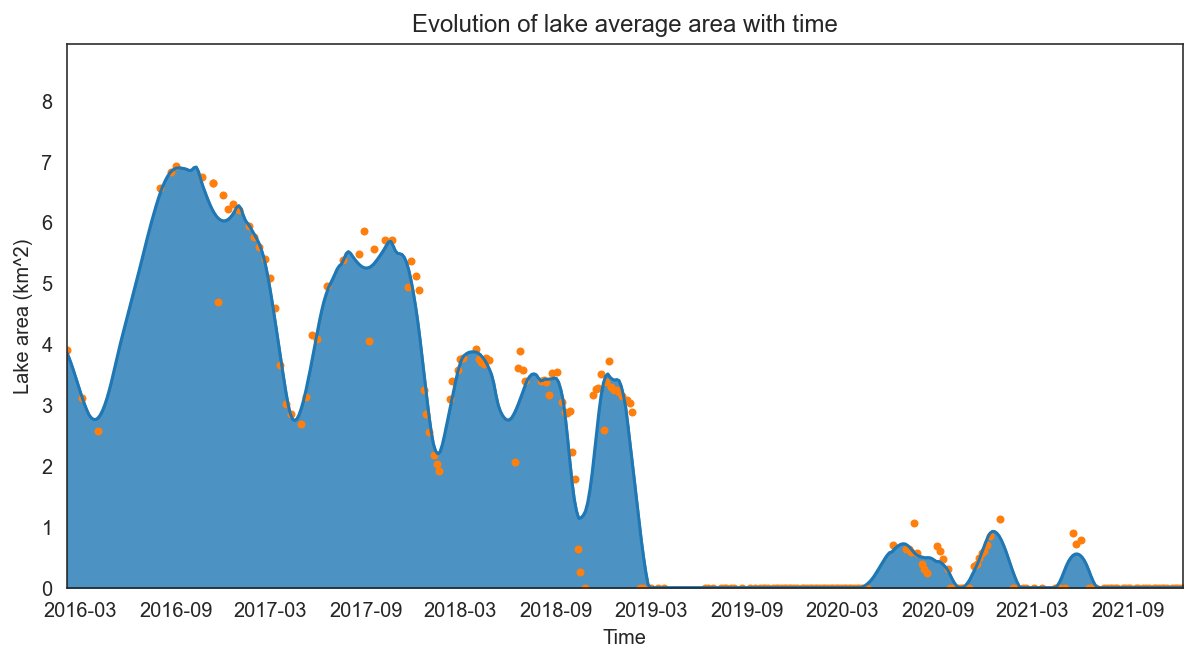

In [19]:
# Discard the points that are too far from the smooth signals (outliers)
l_idx_to_keep = [index for index, error in enumerate(l_relative_error) if error < tresh]
array_area_filtered = array_area[l_idx_to_keep] * 100 / 1000000  # To have km^2 for now
array_data_filtered = array_data_cropped[l_idx_to_keep]
array_times_filtered = np.array(array_times)[l_idx_to_keep]
array_times_int_filtered = np.array(array_times_int)[l_idx_to_keep]
array_segmented_images_filtered = array_segmented_images[l_idx_to_keep]

# Make a last smooth version
f = interp1d(array_times_int_filtered, array_area_filtered, kind="slinear")
xnew = np.linspace(0, array_times_int_filtered[-1], num=500, endpoint=True)
yhat = [x if x >= 0 else 0 for x in savgol_filter(f(xnew), 21, 3)]
x_times = [
    datetime.datetime.fromtimestamp(x) for x in xnew * 10**6 + array_times_filtered[0].timestamp()
]


# Plot the final curve
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(array_times_filtered, array_area_filtered, ".", c="C1")
plt.plot(x_times, yhat, "-", c="C0")
ax.fill_between(x_times, yhat, 0, color="C0", alpha=0.8)
plt.xlabel("Time")
plt.ylabel("Lake area (km^2)")
plt.xlim(array_times_filtered[0], array_times_filtered[-1])
plt.ylim([0, np.max(array_area_filtered + 2)])
# Define the date format
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.title("Evolution of lake average area with time")
plt.show()


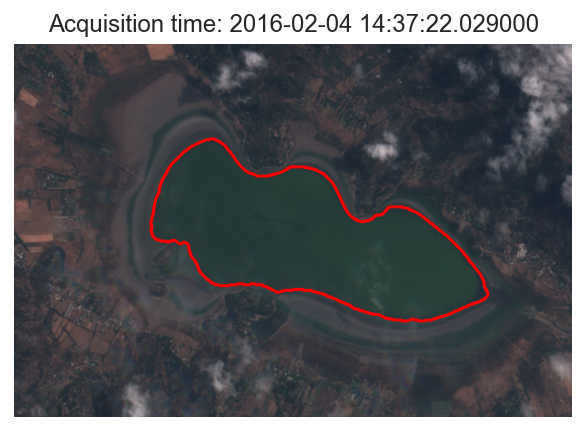

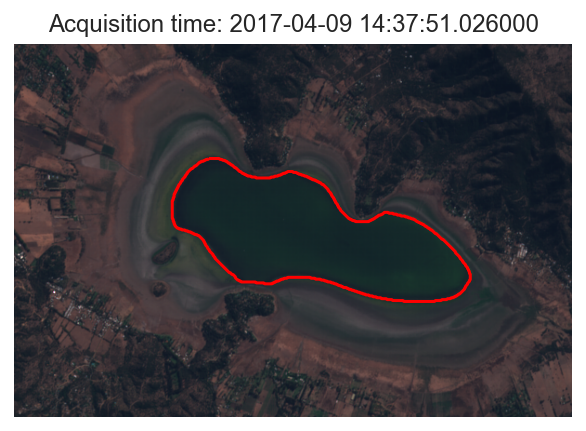

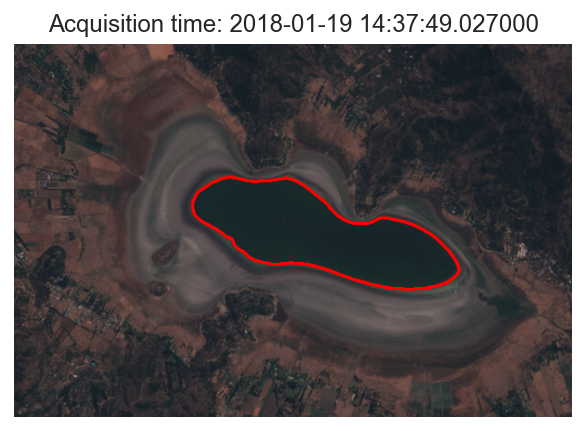

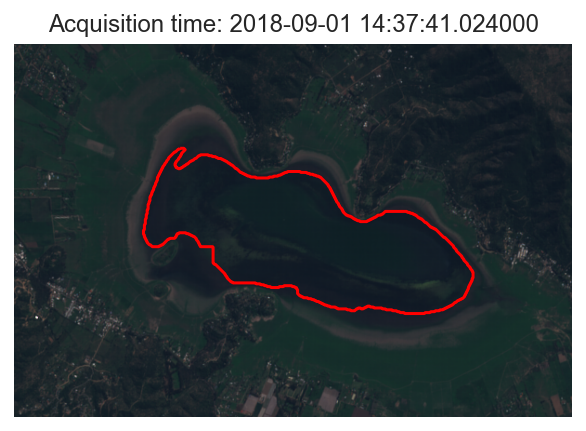

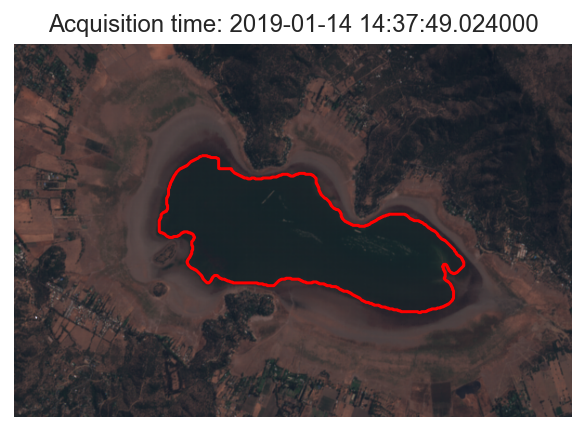

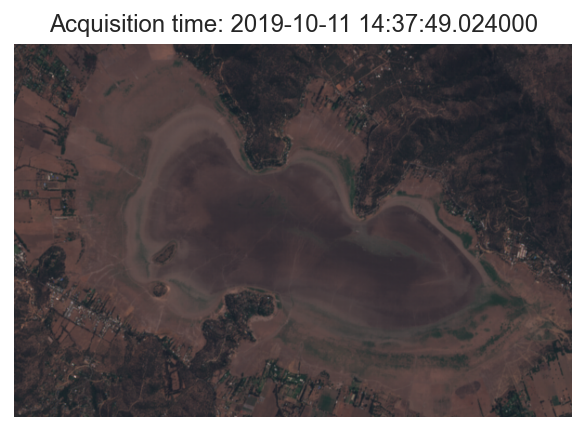

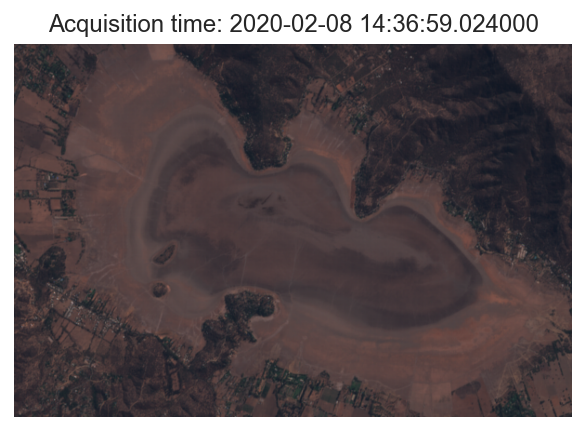

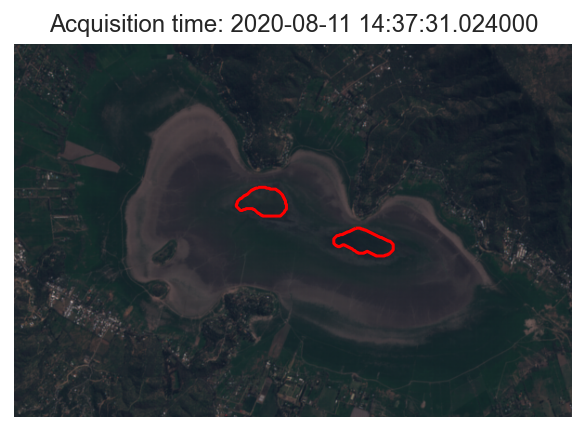

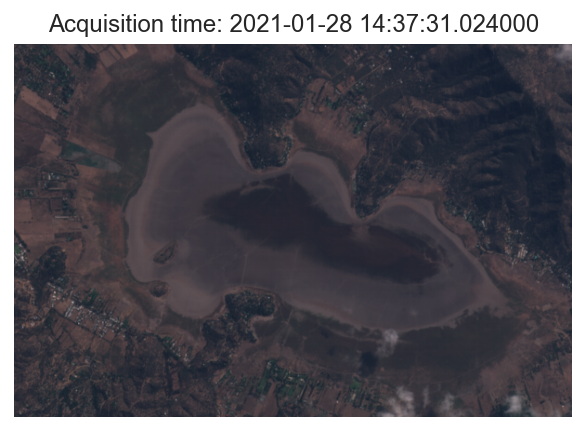

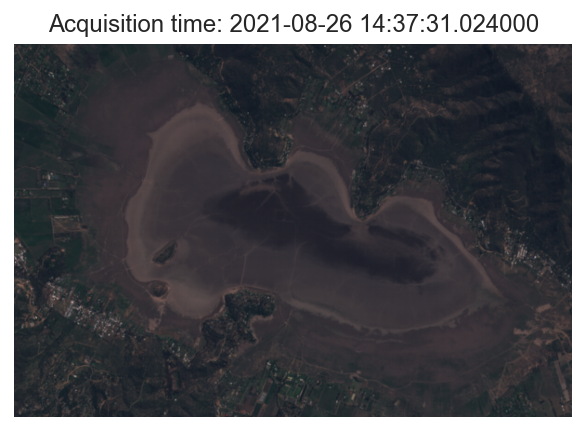

In [20]:
# Display final set of acquisitions
if INTERACTIVE:
    ui, out = visualize_data_interactive(
        array_data_filtered,
        array_segments=array_segmented_images_filtered,
        array_times=array_times_filtered,
    )
    display(ui, out)
else:
    for i in range(0,array_data_filtered.shape[0],22):
        visualize_data_static(
            array_data_filtered, i, array_segments=array_segmented_images_filtered, array_times=array_times_filtered, display_RGB_value = True
        )


It seems that we obtained a pretty good result! The main difficulty is to distinguish grass growing in the mud from algae... But that's quite a minor problem, and our solution works pretty well already. Let's now try to study how the algae content of the water, reflecting its quality, changes over time.

### Study the algae content of the segmented regions

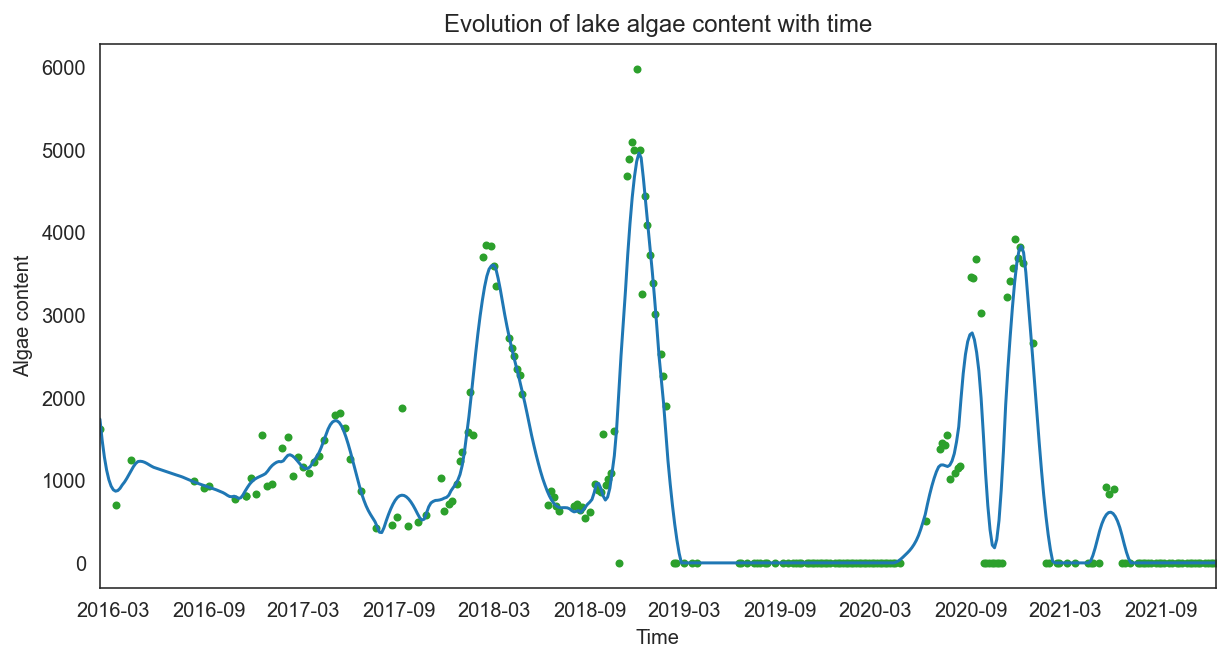

In [21]:
# Compute algae content for each acquisition
l_mean_algae = [
    np.mean(array_data_filtered[index, :, :, 6][segment == 1]) if np.sum(segment) > 0 else 0
    for index, segment in enumerate(array_segmented_images_filtered)
]

# Smooth the signal with a Savgol filter
f = interp1d(array_times_int_filtered, l_mean_algae, kind="slinear")
xnew = np.linspace(0, array_times_int_filtered[-1], num=500, endpoint=True)
yhat_algae = [x if x >= 0 else 0 for x in savgol_filter(f(xnew), 21, 3)]
x_times = [
    datetime.datetime.fromtimestamp(x) for x in xnew * 10**6 + array_times_filtered[0].timestamp()
]

# Plot the final curve
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(array_times_filtered, l_mean_algae, ".", c="C2")
plt.plot(x_times, yhat_algae, "-", c="C0")

plt.xlabel("Time")
plt.ylabel("Algae content")
plt.xlim(array_times_filtered[0], array_times_filtered[-1])
# plt.ylim([0, np.max(array_area_filtered+2000)])
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.title("Evolution of lake algae content with time")
plt.show()


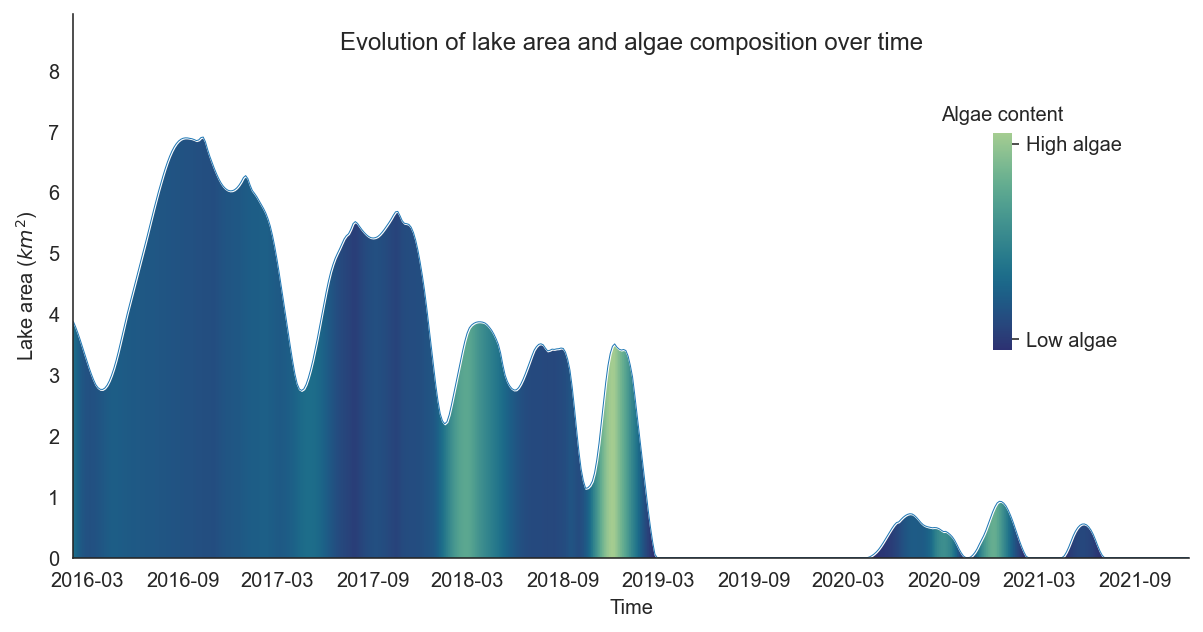

In [22]:
# Scale for main axes
ylims = [0, np.max(array_area_filtered + 2)]
xlims = mdates.date2num([array_times_filtered[0], array_times_filtered[-1]])

# Scale for the colorbar
min_algae = np.min(yhat_algae)
max_algae = np.max(yhat_algae)
scale_algae = max_algae - min_algae

# Draw the image over the whole plot area
fig, ax = plt.subplots(figsize=(10, 5))
im = plt.imshow(
    np.array([yhat_algae]),
    cmap="crest_r",
    origin="lower",
    extent=[xlims[0], xlims[1], ylims[0], ylims[1]],
    aspect="auto",
)

# Erase above the data by filling with white
plt.fill_between(x_times, yhat, ylims[1], color="w")

# Make the line plot over the top
plt.plot(x_times, yhat, "C0", linewidth=0.5)


# Set limits
ax.set_xlim(xlims)
ax.set_ylim(ylims)

# Labels
plt.xlabel("Time")
plt.ylabel("Lake area " + r"($km^2$)")
ax.set_title("Evolution of lake area and algae composition over time", y=1.0, pad=-18)

# More customization
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)


# Define the date format
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))

# add color bar
cbaxes = inset_axes(
    ax,
    width="2%",
    height="50%",
    bbox_to_anchor=[0, 0, 0.85, 0.8],
    bbox_transform=ax.transAxes,
    loc=1,
)
t = fig.colorbar(
    im,
    cax=cbaxes,
    orientation="vertical",
    ticks=[min_algae + scale_algae * 0.05, max_algae - scale_algae * 0.05],
)
cbaxes.set_title("Algae content", size=10)
cbaxes.set_yticklabels(["Low algae", "High algae"], size=10)
t.outline.set_visible(False)

plt.show()


And that's our final result! Pretty cool :D